# Install Module

In [ ]:
!pip install tensorflow Keras numpy pandas imutils scikit-learn matplotlib seaborn flask flask-cors

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Modelling

## Import Package & Module

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten,Input
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
from keras.callbacks import ModelCheckpoint
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
sns.set_style('darkgrid')
from sklearn.metrics import confusion_matrix, classification_report
from IPython.display import display, HTML

## Buka Folder

In [ ]:
# Connect to Google Drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [62]:
# Checking Folder

!ls "drive/MyDrive/dataset"

dataset_daun  dataset_plant  dataset_pohon  model.h5


In [ ]:
# Input File to Variable

from PIL import Image

sdir = '/content/drive/My Drive/dataset/dataset_plant'

filepaths=[]
labels=[]
allowed_extensions = ['.jpg', '.jpeg', '.png']

classlist=os.listdir(sdir)
for klass in classlist:
    classpath=os.path.join(sdir,klass)
    if os.path.isdir(classpath):
        flist=os.listdir(classpath)
        for f in flist:
            fpath=os.path.join(classpath,f)
            extension = os.path.splitext(f)[1].lower()
            if extension in allowed_extensions:  
              try:
                    img = Image.open(fpath)
                    # img = img.resize((224, 224))  # Resize the image to desired size
                    filepaths.append(fpath)
                    labels.append(klass)
              except (OSError, IOError):
                    print("Error opening image:", fpath)
            else:
                print("Unsupported file format:", fpath)
               
Fseries= pd.Series(filepaths, name='filepaths')
Lseries=pd.Series(labels, name='labels')    
df=pd.concat([Fseries, Lseries], axis=1)
print (df.head())
print (df['labels'].value_counts())

Error opening image: /content/drive/My Drive/dataset/dataset_plant/Pohon Kenanga/image5 (200).jpg
Unsupported file format: /content/drive/My Drive/dataset/dataset_plant/Pohon Kenanga/image5 (1).jpe
Unsupported file format: /content/drive/My Drive/dataset/dataset_plant/pohon Matoa/image8 (1).webp
Unsupported file format: /content/drive/My Drive/dataset/dataset_plant/Pohon Saga/image9 (1).gif
Unsupported file format: /content/drive/My Drive/dataset/dataset_plant/pohon Mahoni/image7 (1).bmp
Unsupported file format: /content/drive/My Drive/dataset/dataset_plant/Pohon Jati/image4 (1).gif
Unsupported file format: /content/drive/My Drive/dataset/dataset_plant/Pohon Bungur/image2 (1).jpe
Unsupported file format: /content/drive/My Drive/dataset/dataset_plant/Pohon Bungur/image2 (2).jpe
                                           filepaths         labels
0  /content/drive/My Drive/dataset/dataset_plant/...  Pohon Kenanga
1  /content/drive/My Drive/dataset/dataset_plant/...  Pohon Kenanga
2  /cont

## Split Dataset

In [ ]:
from sklearn.model_selection import train_test_split

train_split = .8
valid_split = .1
dummy_split = valid_split/(1-train_split)

train_dataset_path, dummy_dataset_path= train_test_split(df, test_size=valid_split, stratify=df['labels'], shuffle=True, random_state=123)
test_dataset_path, valid_dataset_path= train_test_split(dummy_dataset_path, test_size=dummy_split, shuffle=True, random_state=123)

print ('train_df length: ', len(train_dataset_path), '  valid_df length: ', len(valid_dataset_path), '  test_df length: ', len(test_dataset_path))


train_df length:  2629   valid_df length:  147   test_df length:  146


In [ ]:
# train_dataset_path
valid_dataset_path

filepaths              labels
593   /content/drive/My Drive/dataset/dataset_plant/...  Pohon Kerai Payung
2863  /content/drive/My Drive/dataset/dataset_plant/...        Pohon Bungur
1596  /content/drive/My Drive/dataset/dataset_plant/...        Pohon Cassia
1370  /content/drive/My Drive/dataset/dataset_plant/...      Pohon Beringin
2641  /content/drive/My Drive/dataset/dataset_plant/...        Pohon Bungur
...                                                 ...                 ...
2611  /content/drive/My Drive/dataset/dataset_plant/...        Pohon Bungur
85    /content/drive/My Drive/dataset/dataset_plant/...       Pohon Kenanga
2074  /content/drive/My Drive/dataset/dataset_plant/...          Pohon Saga
747   /content/drive/My Drive/dataset/dataset_plant/...         pohon Matoa
988   /content/drive/My Drive/dataset/dataset_plant/...      Pohon Trembesi

[147 rows x 2 columns]

In [ ]:
IMG_WIDTH = 224
IMG_HEIGHT = 224
BATCH_SIZE = 64

In [ ]:
train_datagen = ImageDataGenerator(#rotation_range=20,
                                  #  horizontal_flip=True,
                                  #  vertical_flip=True,
                                    rescale=1.0/255,
                                  #zoom_range=0.2,
                                  #width_shift_range=0.2,
                                  #height_shift_range=0.2,
                                  # fill_mode='nearest'
                                   )
train_generator = train_datagen.flow_from_dataframe(train_dataset_path,
                                                    x_col='filepaths',
                                                    y_col='labels',
                                                    target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='categorical',
                                                    color='rgb',
                                                    shuffle=True)




Found 2629 validated image filenames belonging to 10 classes.


In [ ]:
validation_datagen = ImageDataGenerator(#rotation_range=20,
                                        # horizontal_flip=True,
                                        # vertical_flip=True,
                                        rescale=1.0/255,
                                        #zoom_range=0.2,
                                        #width_shift_range=0.2,
                                        #height_shift_range=0.2,
                                        # fill_mode='nearest'
                                        )
validation_generator = validation_datagen.flow_from_dataframe(valid_dataset_path,
                                                              x_col='filepaths',
                                                              y_col='labels',
                                                             target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                             batch_size=BATCH_SIZE,
                                                             class_mode='categorical',
                                                              color='rgb',
                                                             shuffle=True)

Found 147 validated image filenames belonging to 10 classes.


In [ ]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : Pohon Beringin
1 : Pohon Bungur
2 : Pohon Cassia
3 : Pohon Jati
4 : Pohon Kenanga
5 : Pohon Kerai Payung
6 : Pohon Saga
7 : Pohon Trembesi
8 : pohon Mahoni
9 : pohon Matoa


## Cek Image Dataset

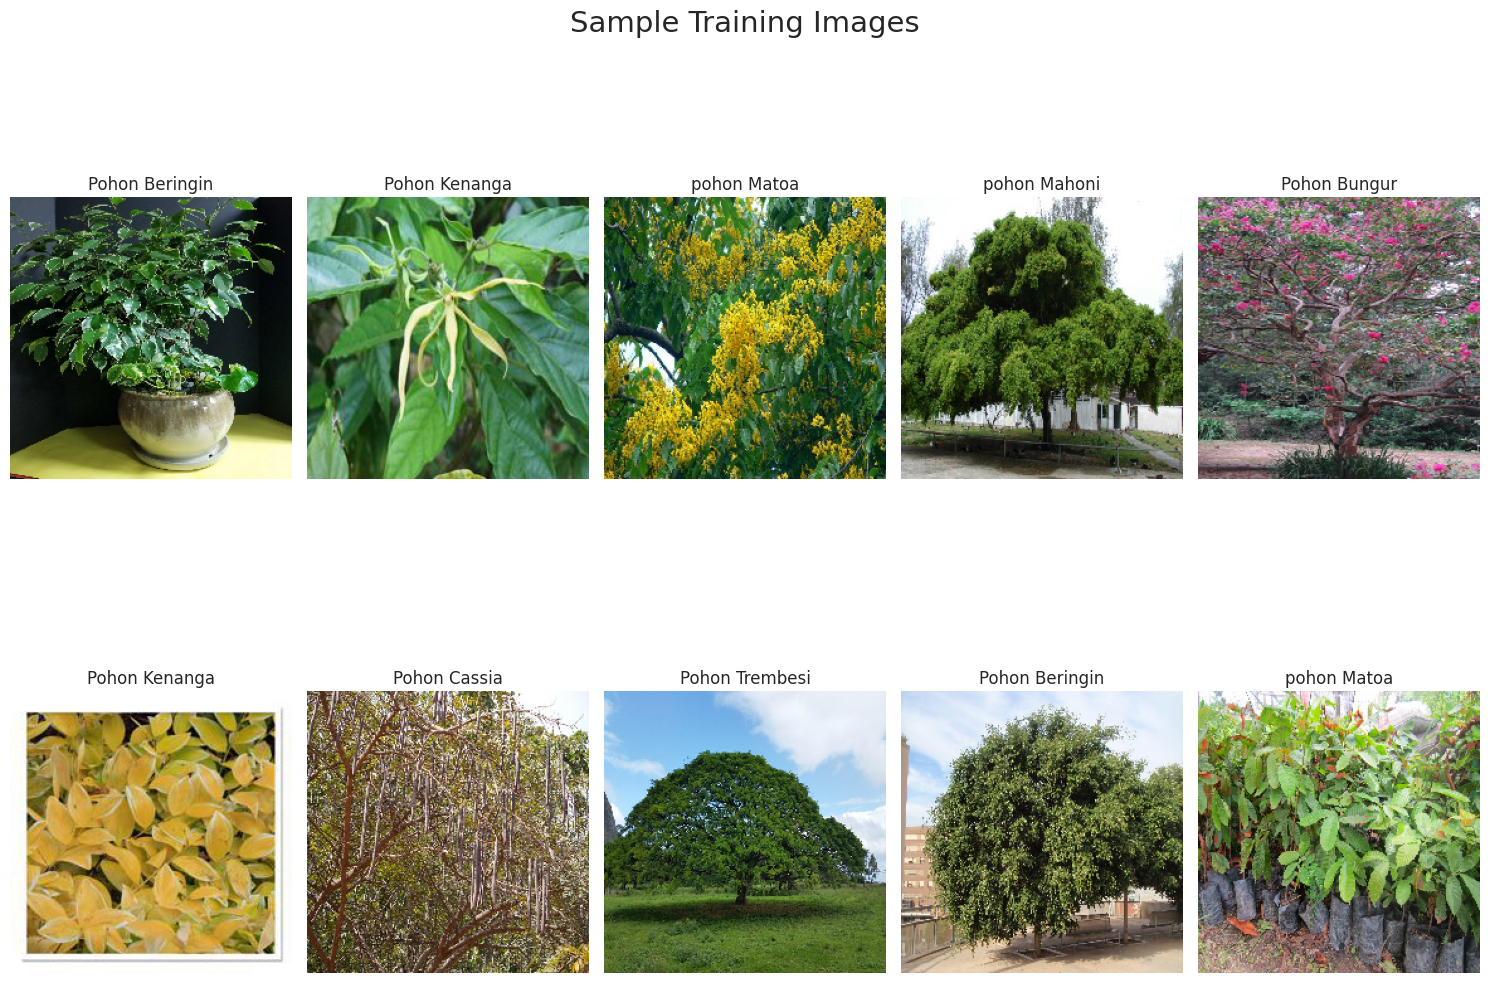

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 12))
idx = 0

for i in range(2):
    for j in range(5):
        label = labels[np.argmax(train_generator[0][1][idx])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(train_generator[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Sample Training Images", fontsize=21)
plt.show()

## Create Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Activation, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2

def create_model():
    model = Sequential([
        Conv2D(filters=64, kernel_size=(5, 5), padding='valid', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
        Activation('relu'),
        # Conv2D(filters=32, kernel_size=(5, 5)),
        # Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        # Dropout(0.5),
        
        # Conv2D(filters=64, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        # Activation('relu'),
        # MaxPooling2D(pool_size=(2, 2)),
        # BatchNormalization(),
        # # Dropout(0.5),
        
        Conv2D(filters=32, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        # Conv2D(filters=64, kernel_size=(3, 3)),
        # Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        # Dropout(0.5),
        
        Flatten(),
        
        Dense(units=64, activation='relu'),
        # Dropout(0.5),
        Dense(units=10, activation='softmax')
    ])

    return model

In [ ]:
cnn_model = create_model()

print(cnn_model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 220, 220, 64)      4864      
                                                                 
 activation_8 (Activation)   (None, 220, 220, 64)      0         
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 110, 110, 64)     0         
 2D)                                                             
                                                                 
 batch_normalization_8 (Batc  (None, 110, 110, 64)     256       
 hNormalization)                                                 
                                                                 
 conv2d_9 (Conv2D)           (None, 108, 108, 32)      18464     
                                                                 
 activation_9 (Activation)   (None, 108, 108, 32)     

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)
optimizer = Adam(learning_rate=0.001)

In [ ]:
from tensorflow.keras.losses import CategoricalCrossentropy
cnn_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# history = cnn_model.fit(train_generator, epochs=50, validation_data=validation_generator, verbose=2, callbacks=[reduce_lr])
with tf.device('/device:GPU:0'):
    history = cnn_model.fit(train_generator, epochs=50, validation_data=validation_generator)

Epoch 1/50
42/42 [==============================] - 78s 1s/step - loss: 8.3625 - accuracy: 0.2746 - val_loss: 2.4709 - val_accuracy: 0.1565
Epoch 2/50
42/42 [==============================] - 42s 985ms/step - loss: 2.1639 - accuracy: 0.5759 - val_loss: 2.6508 - val_accuracy: 0.1361
Epoch 3/50
42/42 [==============================] - 45s 1s/step - loss: 1.0763 - accuracy: 0.7029 - val_loss: 3.5550 - val_accuracy: 0.1293
Epoch 4/50
42/42 [==============================] - 42s 1s/step - loss: 0.6507 - accuracy: 0.8205 - val_loss: 4.6325 - val_accuracy: 0.0748
Epoch 5/50
42/42 [==============================] - 42s 1s/step - loss: 0.7506 - accuracy: 0.8163 - val_loss: 5.2684 - val_accuracy: 0.1769
Epoch 6/50
42/42 [==============================] - 42s 1s/step - loss: 0.4721 - accuracy: 0.8707 - val_loss: 7.9045 - val_accuracy: 0.1293
Epoch 7/50
42/42 [==============================] - 42s 998ms/step - loss: 0.3438 - accuracy: 0.9121 - val_loss: 7.6792 - val_accuracy: 0.1837
Epoch 8/50
42/

## Buat Grafik Training Data

In [ ]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

# learning_rate = history.history['lr']

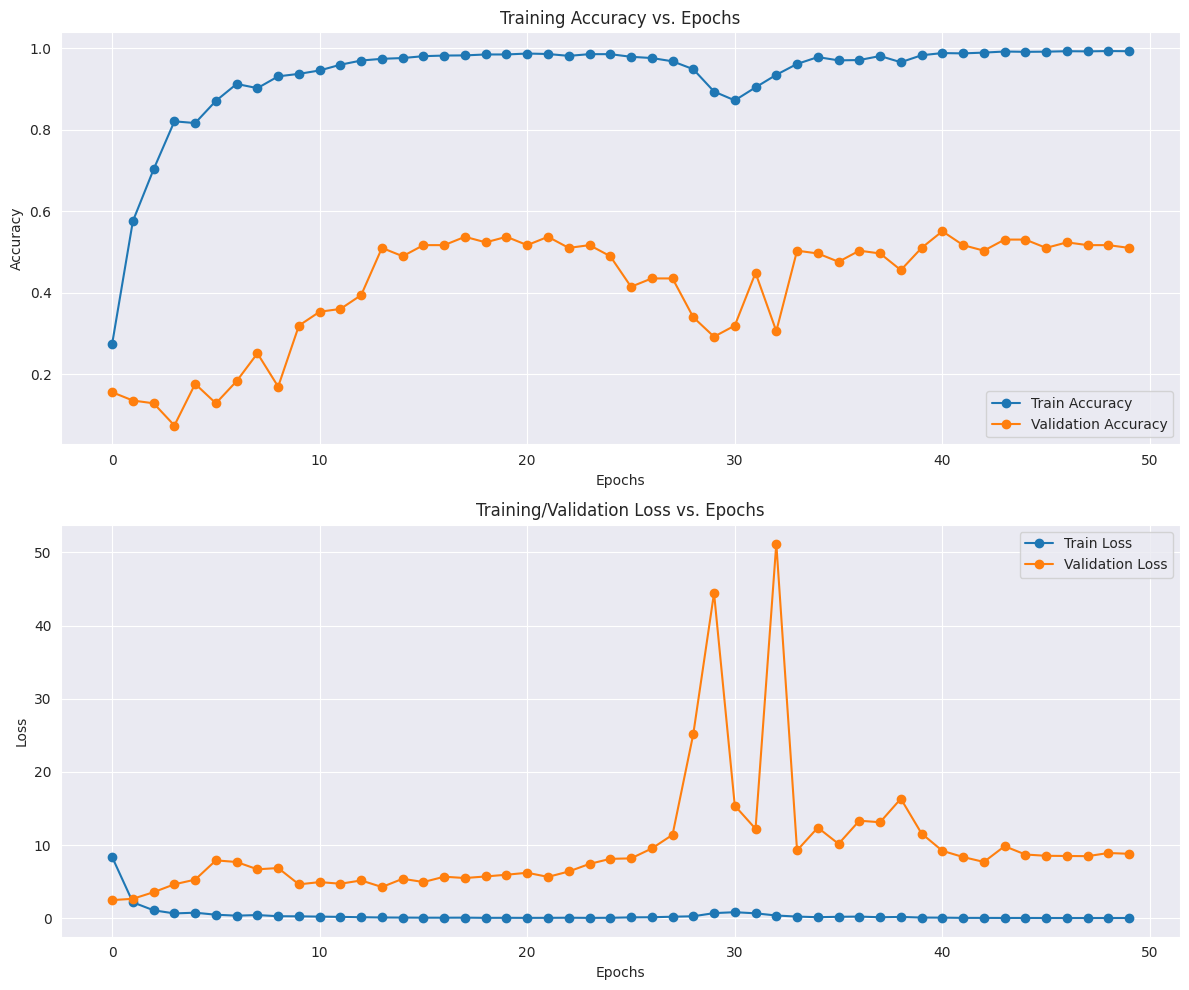

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

# ax[2].set_title('Learning Rate vs. Epochs')
# ax[2].plot(learning_rate, 'o-', label='Learning Rate')
# ax[2].set_xlabel('Epochs')
# ax[2].set_ylabel('Loss')
# ax[2].legend(loc='best')

plt.tight_layout()
plt.show()

## Bikin testing model generator untuk test set

In [ ]:
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_dataframe(test_dataset_path,
                                                  x_col='filepaths',
                                                  y_col='labels',
                                                 shuffle=False,
                                                 batch_size=BATCH_SIZE,
                                                 target_size = (IMG_WIDTH, IMG_HEIGHT),
                                                 class_mode='categorical')

Found 146 validated image filenames belonging to 10 classes.


## modelling prediction buat test set

In [ ]:
predictions = cnn_model.predict(test_generator)

3/3 [==============================] - 3s 1s/step


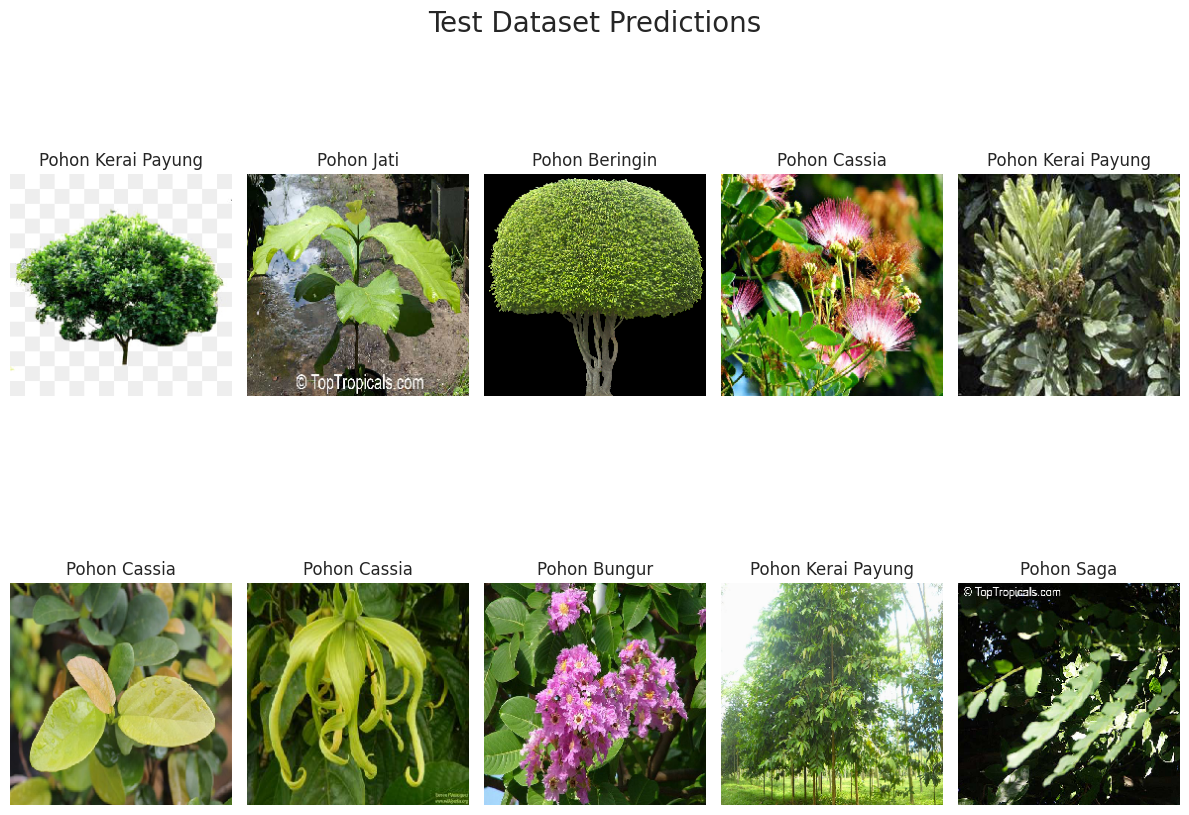

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        predicted_label = labels[np.argmax(predictions[idx])]
        ax[i, j].set_title(f"{predicted_label}")
        ax[i, j].imshow(test_generator[0][0][idx])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Test Dataset Predictions", fontsize=20)
plt.show()

In [ ]:
test_loss, test_accuracy = cnn_model.evaluate(test_generator, batch_size=BATCH_SIZE)

3/3 [==============================] - 2s 557ms/step - loss: 6.3010 - accuracy: 0.6370


In [ ]:
print(f"Test Loss:     {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Test Loss:     6.300988674163818
Test Accuracy: 0.6369863152503967


## Buat Grafik metrik klasifikasinya

In [ ]:
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

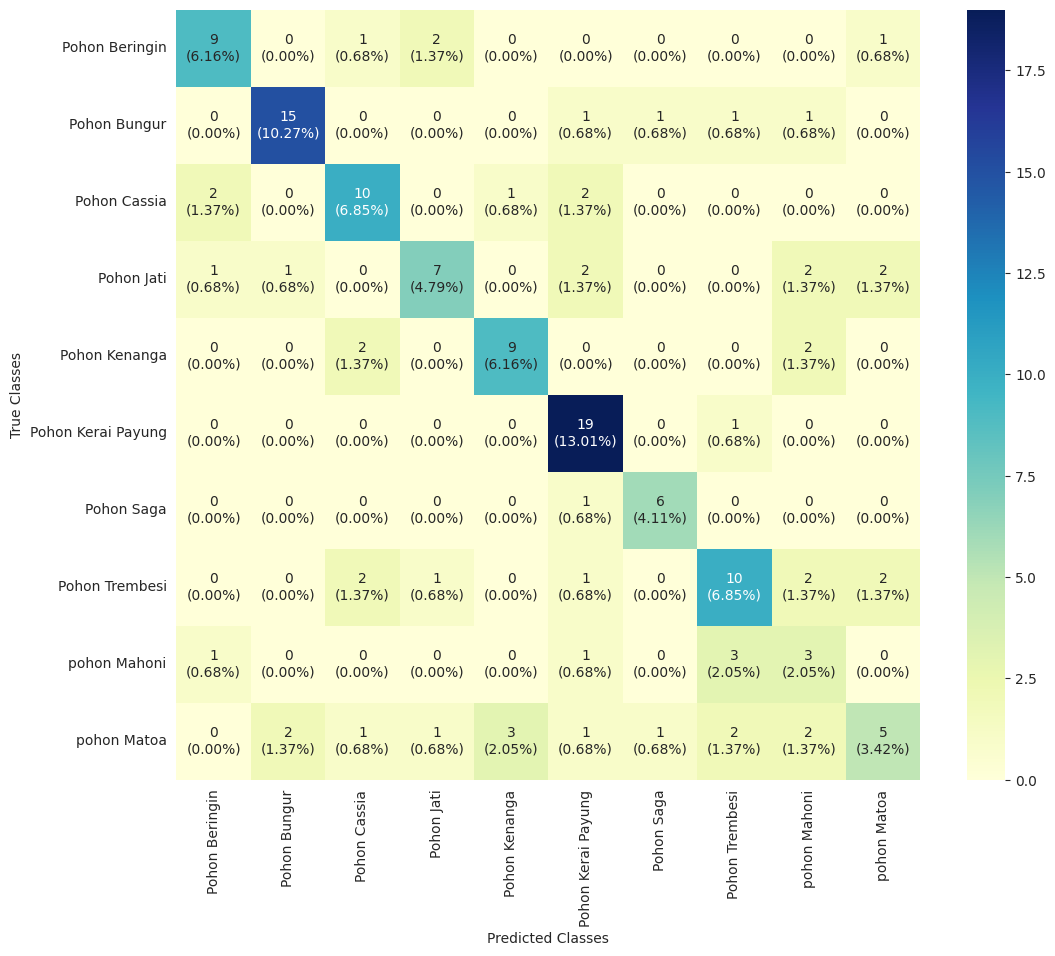

In [ ]:
cf_mtx = confusion_matrix(y_true, y_pred)

group_counts = ["{0:0.0f}".format(value) for value in cf_mtx.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_mtx.flatten()/np.sum(cf_mtx)]
box_labels = [f"{v1}\n({v2})" for v1, v2 in zip(group_counts, group_percentages)]
box_labels = np.asarray(box_labels).reshape(10, 10)

plt.figure(figsize = (12, 10))
sns.heatmap(cf_mtx, xticklabels=labels.values(), yticklabels=labels.values(),
           cmap="YlGnBu", fmt="", annot=box_labels)
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.show()

In [ ]:
print(classification_report(y_true, y_pred, target_names=labels.values()))

                    precision    recall  f1-score   support

    Pohon Beringin       0.69      0.69      0.69        13
      Pohon Bungur       0.83      0.79      0.81        19
      Pohon Cassia       0.62      0.67      0.65        15
        Pohon Jati       0.64      0.47      0.54        15
     Pohon Kenanga       0.69      0.69      0.69        13
Pohon Kerai Payung       0.68      0.95      0.79        20
        Pohon Saga       0.75      0.86      0.80         7
    Pohon Trembesi       0.59      0.56      0.57        18
      pohon Mahoni       0.25      0.38      0.30         8
       pohon Matoa       0.50      0.28      0.36        18

          accuracy                           0.64       146
         macro avg       0.62      0.63      0.62       146
      weighted avg       0.64      0.64      0.63       146



## prediksi yang salah

In [ ]:
# errors = (y_true - y_pred != 0)
# y_true_errors = y_true[errors]
# y_pred_errors = y_pred[errors]

import numpy as np

y_true = np.array(y_true)  # Convert to numpy array if it's not already
y_pred = np.array(y_pred)  # Convert to numpy array if it's not already

errors = np.where(y_true != y_pred)[0]
y_true_errors = y_true[errors]
y_pred_errors = y_pred[errors]


In [ ]:
test_images = test_generator.filenames
test_img = np.asarray(test_images)[errors]

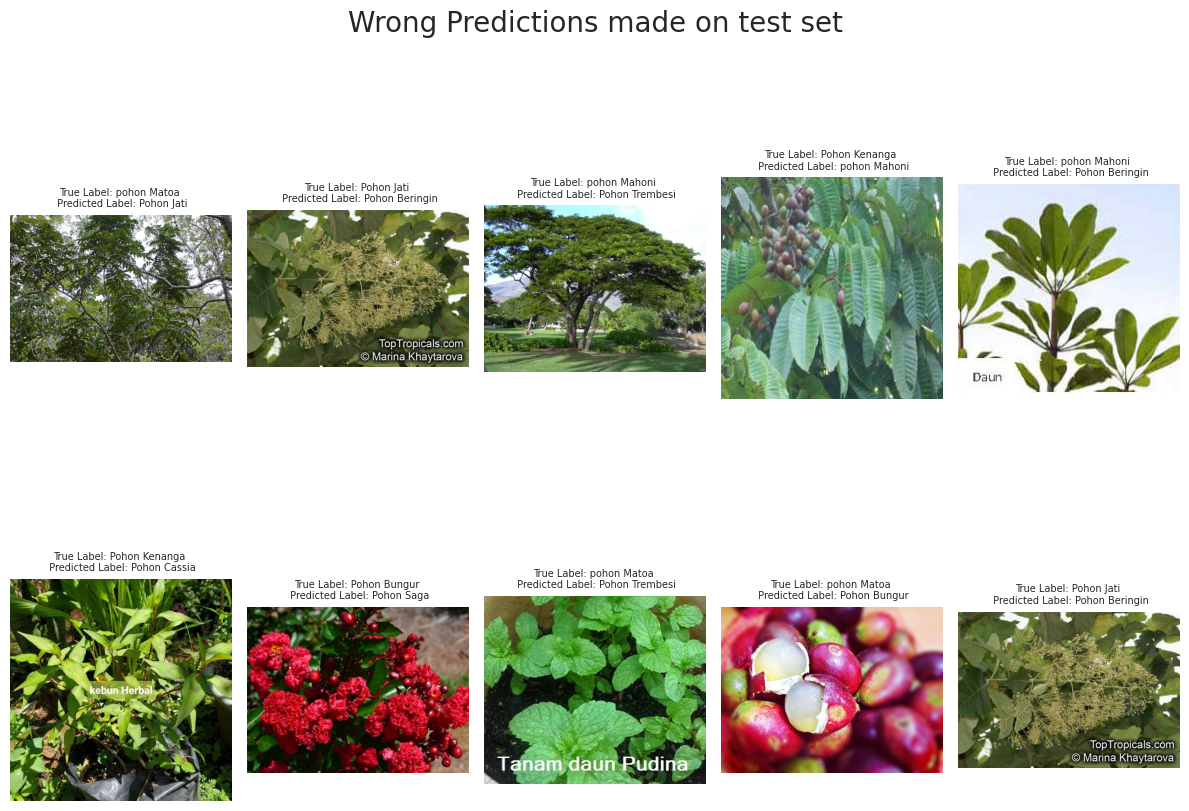

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        idx = np.random.randint(0, len(test_img))
        true_index = y_true_errors[idx]
        true_label = labels[true_index]
        predicted_index = y_pred_errors[idx]
        predicted_label = labels[predicted_index]
        ax[i, j].set_title(f"True Label: {true_label} \n Predicted Label: {predicted_label}", fontsize = 7)
        img_path = os.path.join(test_dataset_path.iloc[idx]['filepaths'], test_img[idx])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax[i, j].imshow(img)
        ax[i, j].axis("off")

plt.tight_layout()
plt.suptitle('Wrong Predictions made on test set', fontsize=20)
plt.show()

## save model h5

In [ ]:
import os
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.models import save_model

# Masuk ke direktori yang diinginkan
os.chdir('/content')

# Simpan model ke file .h5
cnn_model.save('model.h5')

# Mengunduh model
from google.colab import files
files.download('model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>